In [1]:
import numpy as np
import pandas as pd
from gensim.models import KeyedVectors
import matplotlib.pyplot as plt
from collections import Counter

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import cross_val_score, cross_val_predict, KFold
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

from utils import plot_confusion_matrix, OneHotEncoder, clean_and_filter, extract_balanced

print(tf.VERSION)
print(tf.keras.__version__)

In /usr/local/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.unicode rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2.
In /usr/local/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In /usr/local/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The pgf.debug rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2.
In /usr/local/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The verbose.level rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In /usr/local/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The verbose.fileo rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
/usr/local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: 

1.14.0
2.2.4-tf


Loading the data of the [Lakh MIDI Dataset v0.1](https://colinraffel.com/projects/lmd/).
We are interested in the `LMD-aligned`, which contains alignment with the Million Song Dataset (MSD), from which we can extract some metadata.

For each of the 31034 MSD tracks, we have:
- a MIDI file, from which we estracted **embeddings** with [midi2vec](https://github.com/midi-ld/midi2vec);
- a set of **metadata**, from which we extracted:
    - a tag related to the MusicBrainz artist (e.g. 'british', 'pop');
    - a tag related to the EchoNest artist (e.g. 'space rock',  'ballad').
    
Not all the tracks have all the selected tags, and some tags may include dirty text, for example `carlos baute colgando en tus manos nada se compara a ti`

In [2]:
df = pd.read_csv('./lakh/lakh.csv', usecols=['id','song_name','album_name','artist_name','artist_mb','tag_echo','tag_mbz','year'])
df =  df.fillna('?')
df

,id,song_name,album_name,artist_name,artist_mb,tag_echo,tag_mbz,year
0,TRRRUFD12903CD7092,Wastelands,Alien 4,Hawkwind,5a28f8c2-31fb-4047-ae57-c5c326989262,space rock,british,1994
1,TRRRUTV12903CEA11B,Runaway,Songs of Del Shannon,Del Shannon,2e885bfb-1f59-49cf-8d51-e743445e1b48,ballad,classic pop and rock,1961
2,TRRRUJO128E07813E7,Have You Met Miss Jones? (Swing When Version),Swing When You're Winning,Robbie Williams,db4624cf-0e44-481e-a9dc-2142b833ec2f,british pop,pop,2001
3,TRRRIYO128F428CF6F,Goodbye,Bittersweet,Volebeats,eb567c55-368d-4b85-b969-ca9e3252f9cb,alternative country,?,0
4,TRRRILO128F422FFED,La Colegiala,Musica Tropical De Colombia 5,Rodolfo Y Su Tipica Ra7,ead8d6d9-e58b-4dd8-916f-cf7f359db38e,cumbia,?,1997
...,...,...,...,...,...,...,...,...
31029,TRWWYHD12903CC42B1,Gethsemane (I Only Want to Say) (Live-LP Version),In Concert,Michael Crawford,2c654643-cdbd-4634-be26-c4d1a90cfabd,opera,?,0
31030,TRWWYNJ128F426541F,Cold Feelings,Somewhere Between Heaven And Hell,Social Distortion,e1e05cce-3922-44e1-8f20-015abe5e309d,hard rock,punk,1992
31031,TRWWPSV128F4244C71,Ases Death,Dragonchaser,At Vance,17828264-0f4a-40b3-bfc5-8544f30debed,power metal,?,2001
31032,TRWWPBK128F42911E9,Drowned Maid,Chapters,Amorphis,efaefde1-e09b-4d49-9d8e-b1304d2ece8d,progressive metal,finnish,1993


We try to merge strings with similar values (e.g. "hip-hop" and "hip hop") using the Levensthein distance

In [3]:
def merge_near_string(what, distance=1):
    uq = df[what][df[what].notna()].unique()

    import distance

    replace_list = {}
    for w1 in uq:
        if len(w1) < 5:
            continue
        if w1 in replace_list:
            continue
        for w2 in uq:
            if len(w2) < 5:
                continue
            if w1 == w2:
                continue
            if distance.levenshtein(w1,w2) > 1:
                continue
            if w2 in replace_list:
                continue

            replace_list[w2] = w1
    
    for key, value in replace_list.items():
        df[what] = df[what].replace(key, value)
    return replace_list

In [4]:
merge_near_string('tag_mbz')

{'funk rock': 'punk rock',
 'electronica': 'electronic',
 'italia': 'italian',
 'hip hop': 'hip-hop',
 'hiphop': 'hip-hop',
 'australian': 'australia',
 'australie': 'australia',
 'france': 'trance',
 'synth-pop': 'synthpop',
 'orchestral': 'orchestra',
 'popera': 'opera',
 'austria': 'austrian',
 'dark wave': 'darkwave',
 'post rock': 'post-rock',
 'argentine': 'argentina',
 'post-hardcore': 'post hardcore',
 'electropop': 'electro pop'}

In [5]:
merge_near_string('tag_echo')

{'hip pop': 'hip hop',
 'electronica': 'electronic',
 'freakbeat': 'breakbeat',
 'new rave': 'new wave'}

We load the embeddings

In [6]:
emb = KeyedVectors.load_word2vec_format('./lakh/lmd.bin')

In [7]:
ids = [i for i in df.id.tolist() if i in emb]
data = np.array([emb[i] for i in ids])

Some MIDIs do not appear in the list.

These midis had decoding process, so midi2vec did not embed them.

Given that they are a small part of the dataset, we will compute next results without them.

In [8]:
len(df.id.tolist()) - len(data)

59

In [9]:
# filter the df according to the ids
df = df[df.id.isin(ids)]
df

,id,song_name,album_name,artist_name,artist_mb,tag_echo,tag_mbz,year
0,TRRRUFD12903CD7092,Wastelands,Alien 4,Hawkwind,5a28f8c2-31fb-4047-ae57-c5c326989262,space rock,british,1994
1,TRRRUTV12903CEA11B,Runaway,Songs of Del Shannon,Del Shannon,2e885bfb-1f59-49cf-8d51-e743445e1b48,ballad,classic pop and rock,1961
2,TRRRUJO128E07813E7,Have You Met Miss Jones? (Swing When Version),Swing When You're Winning,Robbie Williams,db4624cf-0e44-481e-a9dc-2142b833ec2f,british pop,pop,2001
3,TRRRIYO128F428CF6F,Goodbye,Bittersweet,Volebeats,eb567c55-368d-4b85-b969-ca9e3252f9cb,alternative country,?,0
4,TRRRILO128F422FFED,La Colegiala,Musica Tropical De Colombia 5,Rodolfo Y Su Tipica Ra7,ead8d6d9-e58b-4dd8-916f-cf7f359db38e,cumbia,?,1997
...,...,...,...,...,...,...,...,...
31029,TRWWYHD12903CC42B1,Gethsemane (I Only Want to Say) (Live-LP Version),In Concert,Michael Crawford,2c654643-cdbd-4634-be26-c4d1a90cfabd,opera,?,0
31030,TRWWYNJ128F426541F,Cold Feelings,Somewhere Between Heaven And Hell,Social Distortion,e1e05cce-3922-44e1-8f20-015abe5e309d,hard rock,punk,1992
31031,TRWWPSV128F4244C71,Ases Death,Dragonchaser,At Vance,17828264-0f4a-40b3-bfc5-8544f30debed,power metal,?,2001
31032,TRWWPBK128F42911E9,Drowned Maid,Chapters,Amorphis,efaefde1-e09b-4d49-9d8e-b1304d2ece8d,progressive metal,finnish,1993


### Experiment 1: MusicBrainz Tag 

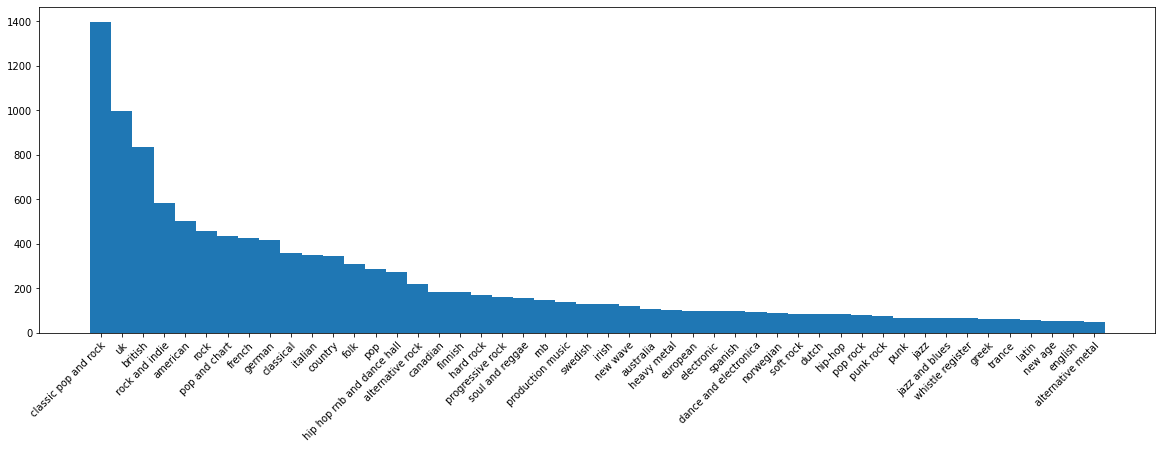

Distinct tag MBZ considered:


48

In [10]:
min_count = 50
data_filtered, tag_mbz_filtered = clean_and_filter(data, df.tag_mbz, min_count=min_count)

print('Distinct tag MBZ considered:')
len(np.unique(tag_mbz_filtered))

In [11]:
data_filtered, tag_mbz_filtered = extract_balanced(data_filtered, tag_mbz_filtered.to_numpy(), min_count)

In [12]:
print('Total elements:')
len(data_filtered)

Total elements:


2400

In [13]:
onehot = OneHotEncoder(tag_mbz_filtered.tolist())

onehot.get(onehot.labels[0])

'alternative metal'

In [14]:
data_filtered.shape

(2400, 100)

In [15]:
onehot.labels.shape

(2400, 48)

In [16]:
num_input = data_filtered.shape[1]
num_output = onehot.labels.shape[1]

num_input, num_output

(100, 48)

We use a Neural Network with 3 dense layers, trained with the Adam Optimizer.

In [17]:
def create_model(num_input, num_output):
    def m():
        model = tf.keras.Sequential()

        model.add(layers.Dense(100, activation='relu', input_shape=(num_input,)))
        model.add(layers.Dense(100, activation='relu'))
        model.add(layers.Dense(num_output, activation='softmax'))

        model.compile(optimizer=tf.train.AdamOptimizer(0.01),
                      loss=tf.keras.losses.CategoricalCrossentropy(),
                      metrics=[tf.keras.metrics.CategoricalAccuracy(name='accuracy')])

        return model
    return m

In [18]:
neural_network = KerasClassifier(build_fn=create_model(num_input, num_output), 
                                 epochs=100, 
                                 batch_size=32, verbose=0)

The network is evaluated with 10-fold cross-validation. The final score is the average of the results.

In [19]:
random_state = 2111
scores = cross_val_score(neural_network, data_filtered, onehot.labels, 
                         cv=KFold(10, shuffle=True, random_state=random_state), verbose=0)
scores

W0625 17:23:21.302016 4782677440 deprecation.py:506] From /usr/local/lib/python3.7/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


array([0.42916667, 0.37083334, 0.41666666, 0.35833332, 0.38749999,
       0.41249999, 0.38333333, 0.375     , 0.38749999, 0.45416668])

In [20]:
np.mean(scores)

0.3974999964237213

In [21]:
predicted = cross_val_predict(neural_network, data_filtered, onehot.labels, 
                         cv=KFold(10, shuffle=True, random_state=random_state), verbose=0)

#### Confusion matrix, without normalization

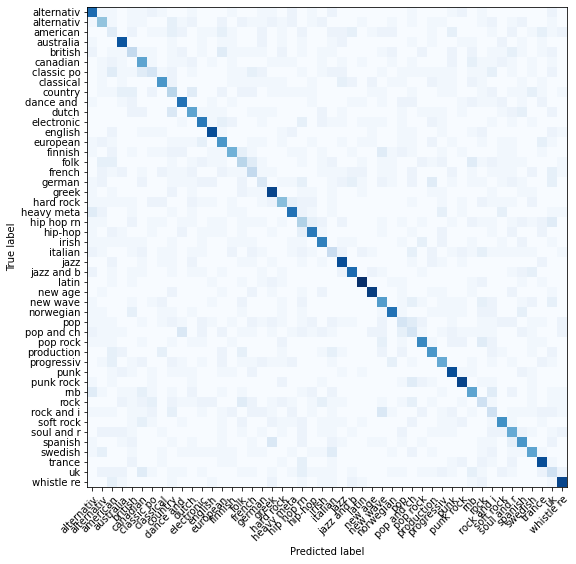

In [22]:
plot_confusion_matrix(onehot.labels, predicted, classes=tag_mbz_filtered, title='mbz', print_values=False)

#### Normalized confusion matrix

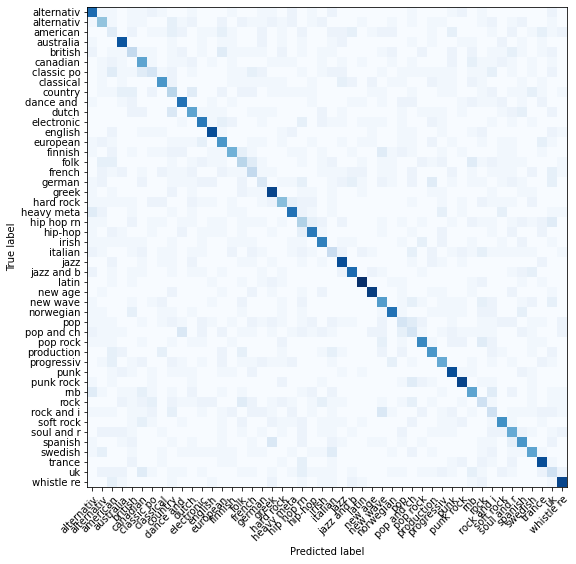

In [23]:
plot_confusion_matrix(onehot.labels, predicted, classes=tag_mbz_filtered, normalize=True, title='mbz', print_values=False)

What are the most confused labels?

In [51]:
y_true = [np.where(r == 1)[0][0] for r in onehot.labels]
cm = confusion_matrix(y_true, predicted)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
classes = np.unique(tag_echo_filtered)
classes = classes[unique_labels(y_true, predicted)]
classes = [c if len(c) > 10 else c for c in classes]

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        if i !=j  and cm[i, j] >= 0.1:
            print(classes[i], classes[j], cm[i, j])

ballad folk rock 0.12
blues-rock ccm 0.14
classic rock british invasion 0.12
cool jazz ccm 0.1
easy listening classic rock 0.12
flamenco british invasion 0.12
folk rock ballad 0.1


### Experiment 2: Tag EchoNest 

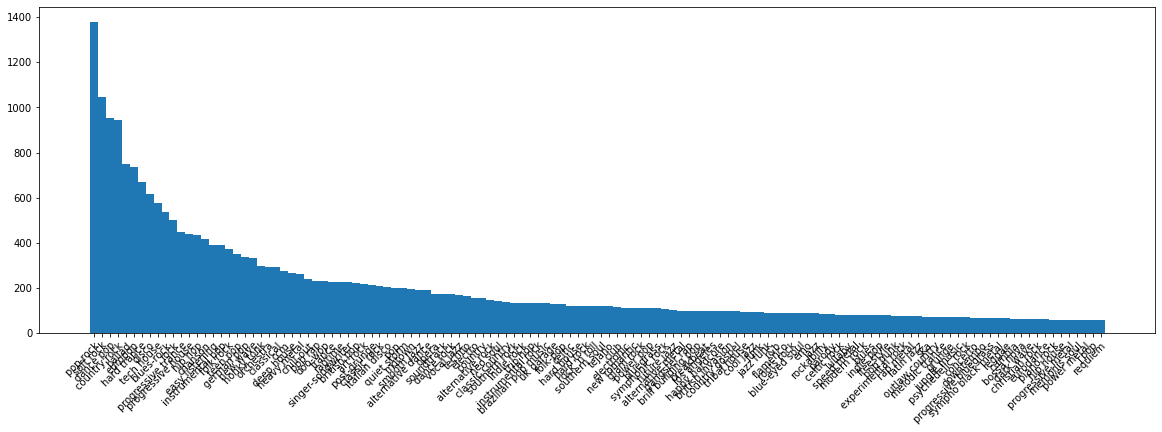

Distinct tag EchoNest considered:


128

In [24]:
data_filtered, tag_echo_filtered = clean_and_filter(data, df.tag_echo, min_count=55)

print('Distinct tag EchoNest considered:')
len(np.unique(tag_echo_filtered))

In [25]:
data_filtered, tag_echo_filtered = extract_balanced(data_filtered, tag_echo_filtered.to_numpy(), min_count)

In [26]:
print('Total elements:')
len(data_filtered)

Total elements:


6400

In [27]:
onehot = OneHotEncoder(tag_echo_filtered.tolist())

onehot.get(onehot.labels[0])

'alternative dance'

In [28]:
num_output = onehot.labels.shape[1]

num_input, num_output

(100, 128)

In [29]:
neural_network = KerasClassifier(build_fn=create_model(num_input, num_output), 
                                 epochs=100, 
                                 batch_size=32,
                                 verbose = 0)

In [32]:
scores = cross_val_score(neural_network, data_filtered, onehot.labels, 
                         cv=KFold(10, shuffle=True, random_state=random_state), verbose=0)
scores

array([0.33281249, 0.31874999, 0.3359375 , 0.35624999, 0.32968751,
       0.28281251, 0.32656249, 0.33750001, 0.3046875 , 0.33125001])

In [33]:
np.mean(scores)

0.32562499940395356

In [34]:
predicted = cross_val_predict(neural_network, data_filtered, onehot.labels, 
                         cv=KFold(10, shuffle=True, random_state=random_state), verbose=0)

In [35]:
def create_model(num_input, num_output):
    def m():
        model = tf.keras.Sequential()

        model.add(layers.Dense(100, activation='relu', input_shape=(num_input,)))
        model.add(layers.Dense(100, activation='relu'))
        model.add(layers.Dense(num_output, activation='softmax'))

        model.compile(optimizer=tf.keras.optimizers.Adam(0.01),
                      loss=tf.keras.losses.CategoricalCrossentropy(),
                      metrics=[tf.keras.metrics.CategoricalAccuracy(name='accuracy')])

        return model
    return m

#### Confusion matrix, without normalization

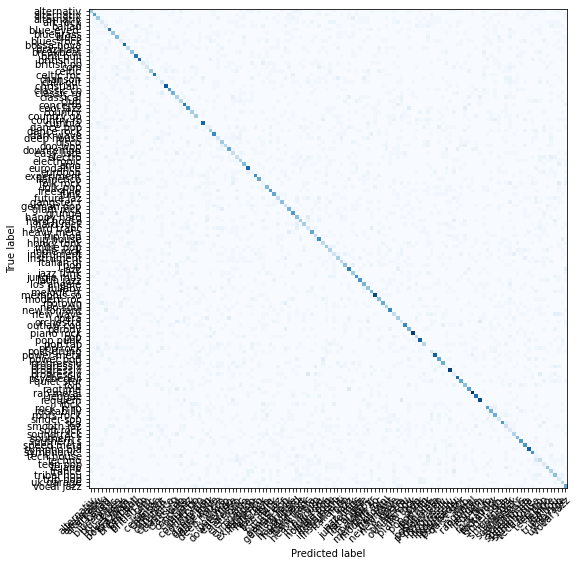

In [36]:
plot_confusion_matrix(onehot.labels, predicted, classes=tag_echo_filtered, title='echo', print_values=False)

#### Normalized confusion matrix

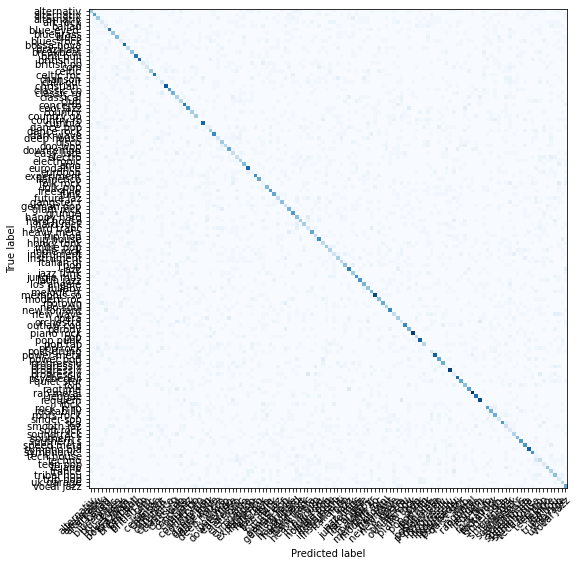

In [37]:
plot_confusion_matrix(onehot.labels, predicted, classes=tag_echo_filtered, normalize=True, title='echo', print_values=False)

What are the most confused labels?

In [38]:
y_true = [np.where(r == 1)[0][0] for r in onehot.labels]
cm = confusion_matrix(y_true, predicted)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
classes = np.unique(tag_echo_filtered)
classes = classes[unique_labels(y_true, predicted)]
classes = [c if len(c) > 10 else c for c in classes]

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        if i !=j  and cm[i, j] >= 0.1:
            print(classes[i], classes[j], cm[i, j])

orchestra requiem 0.1
progressive trance hard trance 0.1
ragtime jazz 0.1
requiem orchestra 0.1
techno tech house 0.1


# 2D Visualisation with TSNE

/usr/local/lib/python3.7/site-packages/matplotlib/backends/_backend_pdf_ps.py:62: RuntimeWarning: Glyph 39321 missing from current font.
  font.set_text(s, 0.0, flags=ft2font.LOAD_NO_HINTING)
/usr/local/lib/python3.7/site-packages/matplotlib/backends/_backend_pdf_ps.py:62: RuntimeWarning: Glyph 28207 missing from current font.
  font.set_text(s, 0.0, flags=ft2font.LOAD_NO_HINTING)
/usr/local/lib/python3.7/site-packages/matplotlib/backends/_backend_pdf_ps.py:62: RuntimeWarning: Glyph 27468 missing from current font.
  font.set_text(s, 0.0, flags=ft2font.LOAD_NO_HINTING)
/usr/local/lib/python3.7/site-packages/matplotlib/backends/_backend_pdf_ps.py:62: RuntimeWarning: Glyph 25163 missing from current font.
  font.set_text(s, 0.0, flags=ft2font.LOAD_NO_HINTING)
/usr/local/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 39321 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/site-packages/matplotlib/backends/ba

Picture saved at ./img/tsne-lakh-mbz.pdf


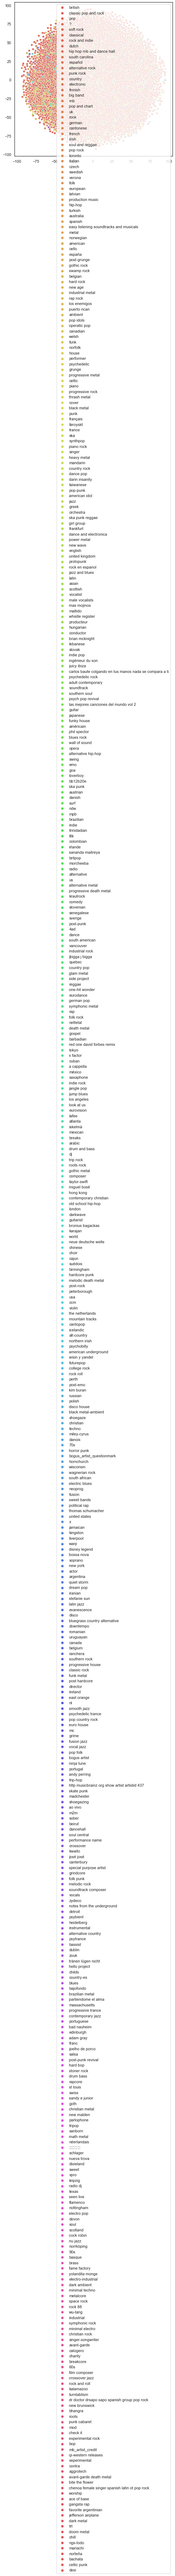

In [39]:
from utils import plot
plot(data, labels=df.tag_mbz.tolist(), output='./img/tsne-lakh-mbz.pdf')

Picture saved at ./img/tsne-lakh-echo.pdf


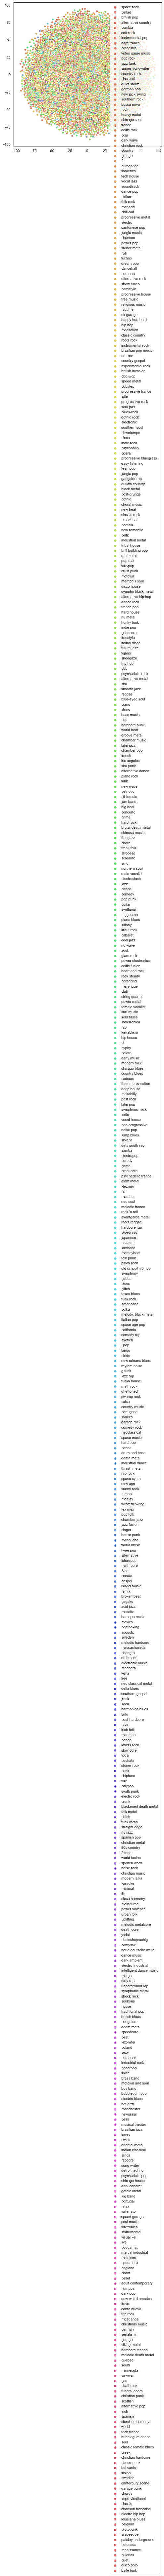

In [40]:
plot(data, labels=df.tag_echo.tolist(), output='./img/tsne-lakh-echo.pdf')